<h2>Here we make a single table with all the merged data, drop or replace N/A, convert units etc.</h2>
I believe that some data preprocessing steps should be model-specific, so until we are done with model selection, I am trying to be conservative with preprocessing

In [39]:
from os import listdir
from os.path import isfile, join
from tqdm.notebook import tqdm

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

In [40]:
# Cool one-liner by pycruft on stackoverflow
# https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

path = "saved_tables"

files = [f for f in listdir(path) if isfile(join(path, f))]

In [42]:
data = pd.DataFrame()

for file in tqdm(files, desc="Merging File"):
    table = pd.read_csv(join(path, file), index_col=0) # Read from file
    
    # The scraped tables feature a number of rows filled with NaNs in the end for some reason - here we get rid of them
    table = table.dropna(how="all") 
    
    table.insert(0, "Date", file[:-4]) # BAD - I don't like in-place operations
    data = pd.concat((data, table)) # Append to the resulting dataframe

Merging File:   0%|          | 0/3619 [00:00<?, ?it/s]

For feature engineering purposes, I don't want to replace neither date nor time with datetime. Keeping the date column allows to formulate the question "Will it rain tomorrow" more easily and the time column might be essential for predictions because it keeps information on the phase in it. Might also be important to add sunset and sunrise info later.

So, here I just make sure that date and time are in their appropriate formats and add datetime as a separate column.

In [43]:
data["Date"] = pd.to_datetime(data["Date"], format="%Y-%m-%d")

# I could use to_datetime and to_timedelta, but in my case this is more elegant:

# Split on : or whitespace (before AM/PM)
hrs, mins, AM_PM = data["Time"].str.split(":|\s", n=2, expand=True).values.T

PM = (AM_PM == "PM").astype(int)
AM12 = (hrs != "12").astype(int) # Mathematically, 12:30 PM is actually 12:30 AM

# Convert into minutes. Multiplying by AM12 prevents adding 12 hours to times like 12:30 PM.
mins_into_day = PM * 12 * 60 * AM12 + hrs.astype(int) * 60 + mins.astype(int)
data.insert(0, "mins_into_day", value=mins_into_day)

Convert temperature and dew point to Kelvin

In [44]:
F = data["Temperature"].str.split(expand=True).values.T[0].astype(float)
K = (F - 32) * 5 / 9 + 273.15
data.insert(3, column="Temp, K", value=K)

F = data["Dew Point"].str.split(expand=True).values.T[0].astype(float)
K = (F - 32) * 5 / 9 + 273.15
data.insert(5, column="Dew Point, K", value=K)

Convert wind speed to m/s. Wind Gust is ignored because it is reported as always at 0.

In [45]:
data["Wind Speed, m/s"] = data["Wind Speed"].str.split(expand=True).values.T[0].astype(float) * 0.44704

Format humidity

In [46]:
data["Humidity"] = data["Humidity"].str.split(expand=True).values.T[0].astype(float)

Convert pressure to pascals

In [47]:
data["Pressure, Pa"] = data["Pressure"].str.split(expand=True).values.T[0].astype(float) * 3386.39

Ordinally encode condition

In [48]:
ord_mapping = {"Fair": 0, "Partly Cloudy": 1, "Mostly Cloudy": 2}
data["condition_ord"] = data["Condition"].map(ord_mapping)

Convert wind direction to azimuth; if it is marked as "VAR", then set the value to -1 and later replace wind speed with 0 in such cases. It would make physical sense that if the wind direction was truly variating so much that not a single direction could be determined, then its average speed over the hour probably cancels out to 0.

In [49]:
az_mapping = {"N": 0, "NNE": 22.5, "NE": 45, "ENE": 67.5,
             "E": 90, "ESE": 112.5, "SE": 135, "SSE": 157.5,
             "S": 180, "SSW": 202.5, "SW": 225, "WSW": 247.5,
             "W": 270, "WNW": 292.5, "NW": 315, "NNW": 337.5,
             "VAR": -1}
data["Wind"] = data["Wind"].map(az_mapping).astype(float)

In [50]:
data

,mins_into_day,Date,Time,"Temp, K",Temperature,"Dew Point, K",Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition,"Wind Speed, m/s","Pressure, Pa",condition_ord
0,410,2015-01-01,6:50 AM,285.927778,55 °F,278.150000,41 °F,58.0,157.5,7 °mph,0 °mph,29.97 °in,0.0 °in,Fair,3.12928,101490.1083,0.0
1,470,2015-01-01,7:50 AM,285.927778,55 °F,278.150000,41 °F,58.0,157.5,7 °mph,0 °mph,30.00 °in,0.0 °in,Fair,3.12928,101591.7000,0.0
2,530,2015-01-01,8:50 AM,288.150000,59 °F,279.261111,43 °F,55.0,112.5,6 °mph,0 °mph,30.03 °in,0.0 °in,Fair,2.68224,101693.2917,0.0
3,590,2015-01-01,9:50 AM,292.038889,66 °F,279.261111,43 °F,43.0,-1.0,3 °mph,0 °mph,30.06 °in,0.0 °in,Fair,1.34112,101794.8834,0.0
4,650,2015-01-01,10:50 AM,294.261111,70 °F,275.927778,37 °F,31.0,-1.0,2 °mph,0 °mph,30.03 °in,0.0 °in,Fair,0.89408,101693.2917,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,890,2024-12-20,2:50 PM,292.038889,66 °F,284.261111,52 °F,60.0,247.5,6 °mph,0 °mph,29.91 °in,0.0 °in,Fair,2.68224,101286.9249,0.0
12,950,2024-12-20,3:50 PM,292.038889,66 °F,282.038889,48 °F,52.0,270.0,5 °mph,0 °mph,29.94 °in,0.0 °in,Fair,2.23520,101388.5166,0.0
13,1010,2024-12-20,4:50 PM,290.927778,64 °F,284.261111,52 °F,64.0,-1.0,2 °mph,0 °mph,29.94 °in,0.0 °in,Fair,0.89408,101388.5166,0.0
14,1070,2024-12-20,5:50 PM,290.372222,63 °F,285.372222,54 °F,72.0,-1.0,3 °mph,0 °mph,29.97 °in,0.0 °in,Fair,1.34112,101490.1083,0.0


Let's clean up the table, get rid of unneeded columns, rearrange the needed ones a bit.

In [51]:
data_clean = data.drop(columns=["Time", "Temperature", "Dew Point", "Humidity", "Wind Speed", "Wind Gust", "Pressure", "Precip.", "Condition"])

In [52]:
data_clean

,mins_into_day,Date,"Temp, K","Dew Point, K",Wind,"Wind Speed, m/s","Pressure, Pa",condition_ord
0,410,2015-01-01,285.927778,278.150000,157.5,3.12928,101490.1083,0.0
1,470,2015-01-01,285.927778,278.150000,157.5,3.12928,101591.7000,0.0
2,530,2015-01-01,288.150000,279.261111,112.5,2.68224,101693.2917,0.0
3,590,2015-01-01,292.038889,279.261111,-1.0,1.34112,101794.8834,0.0
4,650,2015-01-01,294.261111,275.927778,-1.0,0.89408,101693.2917,0.0
...,...,...,...,...,...,...,...,...
11,890,2024-12-20,292.038889,284.261111,247.5,2.68224,101286.9249,0.0
12,950,2024-12-20,292.038889,282.038889,270.0,2.23520,101388.5166,0.0
13,1010,2024-12-20,290.927778,284.261111,-1.0,0.89408,101388.5166,0.0
14,1070,2024-12-20,290.372222,285.372222,-1.0,1.34112,101490.1083,0.0


In [53]:
start_of_day = data_clean.groupby("Date").agg({"mins_into_day": ["min"]}).values

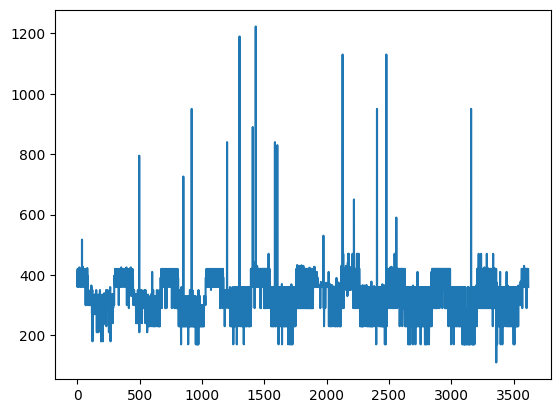

In [55]:
plt.plot(start_of_day)
plt.show()

We can clearly see DST in this graph. Let's adjust for it manually.

In [56]:
DST_list = [["27-03-2015", "25-10-2015"],
           ["25-03-2015", "30-10-2015"],
           ["24-03-2015", "29-10-2015"]]

The next step is to merge with the rain data. 

In [16]:
pd.read_csv("data/data_202412211441.csv")

,Station,Date & Time (Winter),Rainfall per minute (mm),Rain Correction (mm)
0,Haifa Technion_1m,01/12/2021 04:11,0.1,0.1
1,Haifa University_1m,01/12/2021 04:12,0.1,-
2,Haifa University_1m,01/12/2021 04:13,0.1,-
3,Haifa Technion_1m,01/12/2021 04:13,0.1,0.1
4,Haifa University_1m,01/12/2021 04:14,0.1,-
...,...,...,...,...
36128,Haifa Refineries_1m,20/12/2024 07:14,0.1,-
36129,Haifa Refineries_1m,20/12/2024 07:17,0.1,-
36130,Haifa Refineries_1m,20/12/2024 07:19,0.1,-
36131,Haifa Technion_1m,20/12/2024 07:19,0.1,0.1
